# Configurar o ambiente



Necessário apenas instalar a biblioteca biopython com PIP (porque o python já vem por padrão neste servidor).

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.9 MB/s eta 0:00:00


# Exercício 1

**Objetivo**: reconhecer operações essenciais de sequência (tamanho, slicing, GC, transcrição, tradução).

Considere o código abaixo como base e exemplo para os exercícios a seguir:

In [1]:
from Bio.Seq import Seq
seq = Seq("ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG")
print("len:", len(seq))
print("primeiros 10 nt:", seq[:10])
print("A:", seq.count("A"), "C:", seq.count("C"), "G:", seq.count("G"), "T:", seq.count("T"))

revcomp = seq.reverse_complement()
print("revcomp:", revcomp)

rna = seq.transcribe()
prot = seq.translate(to_stop=True)
print("RNA:", rna)
print("Prot:", prot)

len: 39
primeiros 10 nt: ATGGCCATTG
A: 9 C: 8 G: 14 T: 8
revcomp: CTATCGGGCACCCTTTCAGCGGCCCATTACAATGGCCAT
RNA: AUGGCCAUUGUAAUGGGCCGCUGAAAGGGUGCCCGAUAG
Prot: MAIVMGR


1a: Escreva uma função gc(seq) que retorne %GC com 2 casas.

In [6]:
def gc(seq):
    totalC = seq.count("C")
    totalG = seq.count("G")
    return round((totalG + totalC)/len(seq) * 100,2)
x = gc(seq)
x

56.41

1b: Agora teste em seq e em revcomp (o %GC muda? por quê?)

In [7]:
y = gc(revcomp)
y

56.41

Nao, pois revcomp eh o par complementar de seq, e como o par de C eh G, nada muda

1c (para casa): Verifique se seq contém o motivo GGG (use o operador in) e retorne as posições onde ocorre

In [9]:
motif = "GGG"
positions = []
start = 0
while True:
    pos = seq.find(motif, start)
    if pos == -1:
        break
    positions.append(pos)
    start = pos + 1
print(positions)

[14, 26]


# Exercício 2

**Objetivo**: fazer parsing de FASTA, sumarizar, filtrar e gravar resultados.

Considere o código abaixo como base e exemplo para os exercícios a seguir:

In [10]:
from Bio import SeqIO

def gc(seq):
    s = str(seq).upper()
    return 100*(s.count("G")+s.count("C"))/len(s)

in_fa = "Genomas_filoviridae.fasta"  # troque pelo seu caminho

n = 0
tamanhos, gcs = [], []
for rec in SeqIO.parse(in_fa, "fasta"):
    n += 1
    tamanhos.append(len(rec.seq))
    gcs.append(gc(rec.seq))
print(f"lidas {n} sequências")
print("tamanho médio:", sum(tamanhos)/len(tamanhos))
print("GC médio:", sum(gcs)/len(gcs))

lidas 833 sequências
tamanho médio: 18917.597839135655
GC médio: 40.93000407855796


2a: Pesquisando em um livro de virologia, você descobriu que o genoma completo de Filovirus deve ser sempre maior do que 18700 nucleotídeos. Filtre e salve em `filtered.fasta` apenas as sequências de genoma completo de Filoviridae. Quantas sequências foram removidas por não serem genomas completos?

In [11]:
filtered_fasta = []
count = 0
for rec in SeqIO.parse(in_fa, "fasta"):
    if len(rec.seq) >= 18700:
        filtered_fasta.append(rec)
        count += 1
print(f"sequências filtradas: {n-count}")
SeqIO.write(filtered_fasta, "filtered.fasta", "fasta")

sequências filtradas: 18


815

2b: Crie um CSV com id, length, gc para todas as sequências.

In [15]:
import pandas as pd


rows = []
for rec in SeqIO.parse("filtered.fasta", "fasta"):
        rows.append({
        "id": rec.id,
        "length": len(rec.seq),
        "gc": round(gc(rec.seq), 2)  
    })
df = pd.DataFrame(rows)
with open("filtered.csv", "w") as f:
    f.write(df.to_csv(index=False))
    

# Exercício 3

**Objetivo**: Ler FASTQ, acessar qualidades Phrede filtrar de forma simples as sequências.

Considere o código abaixo como base e exemplo para os exercícios a seguir:

In [16]:
from Bio import SeqIO
import statistics as stats

in_fq = "Exemplo_sequencias_R1.fastq"  # troque pelo seu caminho

qual_medias = []
comprimentos = []
for rec in SeqIO.parse(in_fq, "fastq"):  # assume FASTQ Sanger (Phred+33)
    q = rec.letter_annotations["phred_quality"]
    qual_medias.append(sum(q)/len(q))
    comprimentos.append(len(rec))
print("reads:", len(qual_medias),
      "| média das médias de Q:", round(sum(qual_medias)/len(qual_medias), 2),
      "| tamanho médio:", round(sum(comprimentos)/len(comprimentos), 1))

reads: 110185 | média das médias de Q: 33.42 | tamanho médio: 115.1


3a: Grave em `highq.fastq` apenas as reads com média de Q ≥ 25 e len ≥ 75.

In [20]:
with open("highq.fastq", "w") as f:
    for rec in SeqIO.parse(in_fq, "fastq"):
        q = rec.letter_annotations["phred_quality"]
        if sum(q)/len(q) >= 25 and len(rec) <= 75:
            SeqIO.write(rec, f, "fastq")
        

3b (Desafio): Pegue todas as sequências do arquivo FASTQ e calcule a probabilidade média de erro (convertida a partir da fórmula do Phred) para cada posição da sequência.  
Por exemplo, qual a chance de erro na posição 1 de todas as sequências? E na posição 2? Assim por diante.  
Faça um histrograma da probabilidade média de erro por posição da sequência para identificar algum padrão (Quem identificar, me conta depois ;)

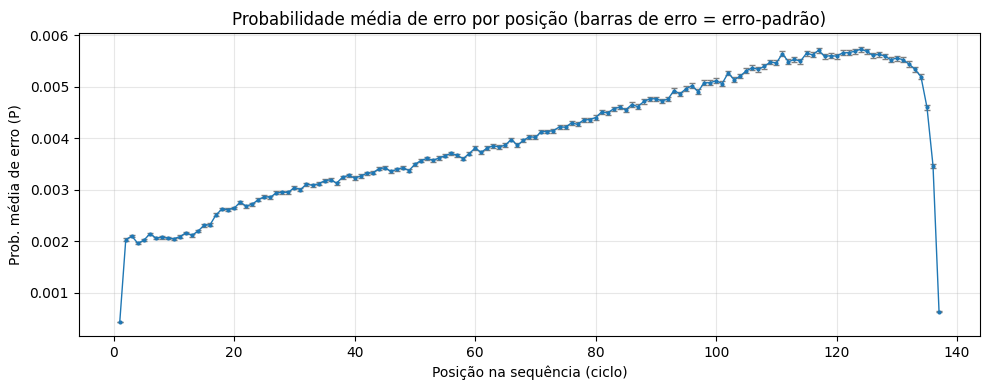

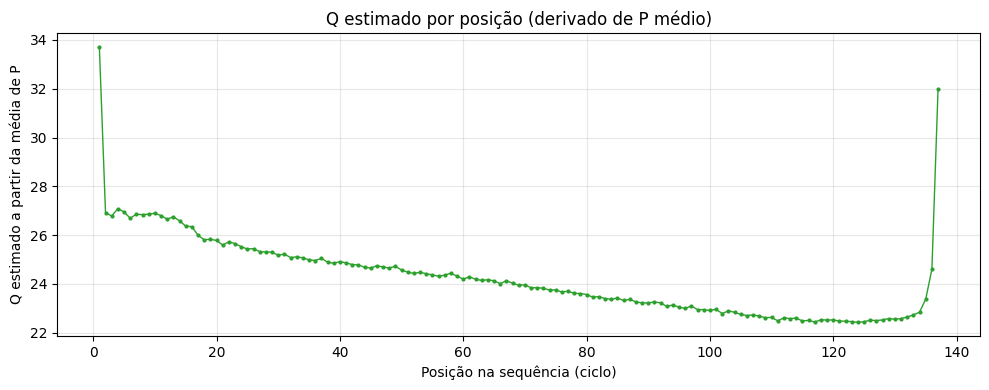

In [ ]:
from Bio import SeqIO 
import numpy as np
import matplotlib.pyplot as plt
import math

in_fq = "Exemplo_sequencias_R1.fastq"

tamanho_max = 0 #tinha em algum lugar, mas nao lembro onde; mais facil
for rec in SeqIO.parse(in_fq, "fastq"):
    tamanho_max = max(tamanho_max, len(rec.seq))

# Acumuladores por posição p/ média e variância
counts = np.zeros(tamanho_max, dtype=np.int64)
sumP = np.zeros(tamanho_max, dtype=np.float64)
sumP2 = np.zeros(tamanho_max, dtype=np.float64)

# converter Q->P e agregar
for rec in SeqIO.parse(in_fq, "fastq"):
    quals = rec.letter_annotations["phred_quality"]
    for i, Q in enumerate(quals):
        P = 10 ** (-Q / 10.0) 
        sumP[i] += P
        sumP2[i] += P * P
        counts[i] += 1

# Estatísticas por posição p/ as barras de erro
posicoes = np.arange(1, tamanho_max + 1)
meanP = np.full(tamanho_max, np.nan, dtype=np.float64)
sdP = np.full(tamanho_max, np.nan, dtype=np.float64) # Vai mostrar a variação daquela posição entre as leituras
seP = np.full(tamanho_max, np.nan, dtype=np.float64) # Esse já mostra a incerteza da média

mask = counts > 0
meanP[mask] = sumP[mask] / counts[mask]
# variância amostral (n>1); para n=1, SD fica NaN
varP = np.full(tamanho_max, np.nan, dtype=np.float64)
mask_n_gt1 = counts > 1
varP[mask_n_gt1] = (sumP2[mask_n_gt1] - (sumP[mask_n_gt1]**2)/counts[mask_n_gt1]) / (counts[mask_n_gt1] - 1)
sdP[mask_n_gt1] = np.sqrt(np.clip(varP[mask_n_gt1], 0, np.inf))
seP[mask_n_gt1] = sdP[mask_n_gt1] / np.sqrt(counts[mask_n_gt1])

# Plot: média de P por posição com barras de erro
plt.figure(figsize=(10, 4))
# Dá pra trocar o sdP ou seP pra ver a diferença
plt.errorbar(posicoes[mask], meanP[mask], yerr=seP[mask], fmt='-o', ms=2, lw=1, ecolor='tab:gray', elinewidth=0.8, capsize=2)
plt.xlabel('Posição na sequência (ciclo)')
plt.ylabel('Prob. média de erro (P)')
plt.title('Probabilidade média de erro por posição (barras de erro = erro-padrão)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Versão em Q médio estimado a partir da média de P (o q pode ser meio estranho, mas dá uma ideia da conversão contrária)
# Observação: Q = -10*log10(P); média de Q não é igual a Q da média de P,
# mas Q(meanP) é útil como escala familiar em dB.
Q_from_meanP = np.where(meanP > 0, -10*np.log10(meanP), np.nan)
plt.figure(figsize=(10, 4))
plt.plot(posicoes[mask], Q_from_meanP[mask], '-o', ms=2, lw=1, color='tab:green')
plt.xlabel('Posição na sequência (ciclo)')
plt.ylabel('Q estimado a partir da média de P')
plt.title('Q estimado por posição (derivado de P médio)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


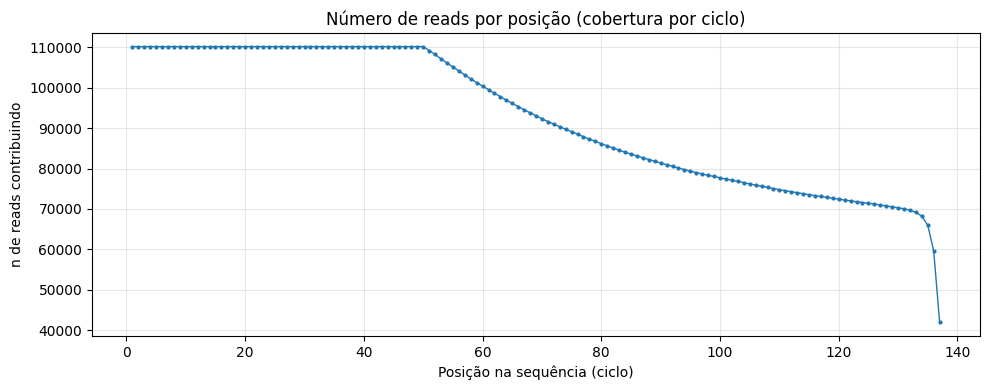

In [ ]:
### Esse plot mostra o número de reads que contribuem por posição, e vai mostrar que tem muitos reads pequenos (<50pb) e poucos > 130 pb
# E isso contribui pros saltos de qualidade que vemos no gráfico de Q médio por posição e no de probabilidade tbm
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt

in_fq = "Exemplo_sequencias_R1.fastq"

tamanho_max = 0 #tinha em algum lugar, mas nao lembro onde; mais facil
for rec in SeqIO.parse(in_fq, "fastq"):
    tamanho_max = max(tamanho_max, len(rec.seq))

# Contagem de reads que alcançam cada posição
counts = np.zeros(tamanho_max, dtype=np.int64)

for rec in SeqIO.parse(in_fq, "fastq"):
    # conta até o tamanho da qualidade/seq da read
    npos = len(rec.letter_annotations["phred_quality"])
    if npos > 0:
        counts[:npos] += 1

# Plot: n por posição
posicoes = np.arange(1, tamanho_max + 1)

plt.figure(figsize=(10, 4))
plt.plot(posicoes, counts, '-o', ms=2, lw=1)
plt.xlabel('Posição na sequência (ciclo)')
plt.ylabel('n de reads contribuindo')
plt.title('Número de reads por posição (cobertura por ciclo)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
